### [Nearest Neighbors](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors)
- *unsupervised* NN = basis for manifold learning, spectral clustering & kernel density estimation.
- *supervised* NN = used for *classification* (discrete labels) and *regression* (continuous labels)
- basics: find a *set of training samples* closest to a new point & predict the label based on them. The #samples can be predefined (*kNN*) or based on a local density (*radius-based-NN*).
- Any distance metric can be used - Euclidean is typical.
- NN is described as "non-generalizing" - it uses all of its training data.
- Can use dense (NumPy) or sparse (SciPy.sparse) input matrices.

### [Unsupervised NN](https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-nearest-neighbors)
- Four basic algorithm options, set using `algorithm=<keyword>`:
    - [`BallTree`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)
    - [`KDTree`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree)
    - [Pairwise "`brute` force"](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise)
    - `auto`: the best approach is determined by the method.

In [2]:
from sklearn.neighbors import NearestNeighbors as NN
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NN(n_neighbors=2, 
          algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

print(distances,indices)

[[0.         1.        ]
 [0.         1.        ]
 [0.         1.41421356]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.41421356]] [[0 1]
 [1 0]
 [2 1]
 [3 4]
 [4 3]
 [5 4]]


### Example: Return a sparse graph w/ connections between points
- Data is structured so that nearby points (in index order) are also nearby in parameter space (an approximately block-diagonal matrix of KNNs).

In [3]:
nbrs.kneighbors_graph(X).toarray()

array([[1., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1.]])

### Example: KDTree implementation
- The Ball Tree variant looks very similar.

In [4]:
from sklearn.neighbors import KDTree
import numpy as np

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

kdt = KDTree(X, leaf_size=30, metric='euclidean')
kdt.query(X, k=2, return_distance=False)

array([[0, 1],
       [1, 0],
       [2, 1],
       [3, 4],
       [4, 3],
       [5, 4]])

In [5]:
# return a list of valid metrics
from sklearn.neighbors import KDTree, BallTree
print(KDTree.valid_metrics)
print(BallTree.valid_metrics)

['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity']
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'hamming', 'canberra', 'braycurtis', 'jaccard', 'dice', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'pyfunc']


### [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) and [Radius-based NN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier) Classification
- Classes are assigned from a simple majority vote of NNs of each point.
- **KNN** is most commonly used; optimal $k$ is very data-dependent.
- **Radius-based NNs** more useful when data can't be uniformly sampled. Depends on radius $r$ - points in sparser neighborhoods use fewer NNs for classification. Radius-based NNs suffer from dimensionality problems in high-dimension datasets.
- Basic classification uses `weights=uniform` to compute a simple majority vote of NNs. `weights=distance` assigns weights proportional to the inverse of distance from the query point. (You can also define a custom distance function.)

### [Example: 3-class KNN - uniform vs distance weights](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html)
- train on Iris dataset
- observe how `weights` changes the decision boundary

In [6]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris(as_frame=True)
X = iris.data[["sepal length (cm)", "sepal width (cm)"]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [7]:
# KNN uses euclidean distance - important to scale data before fitting

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline(
    steps=[("scaler", StandardScaler()), 
           ("knn", KNeighborsClassifier(n_neighbors=11))])

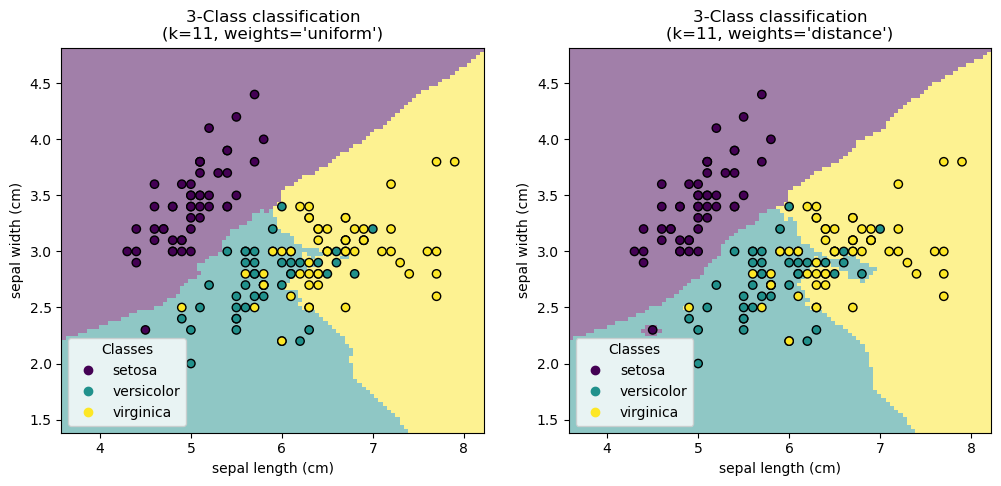

In [8]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        iris.target_names,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

### [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) and [Radius-based NN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html#sklearn.neighbors.RadiusNeighborsRegressor) Regression
- Can be used __when data labels are continuous__, not discrete. Labels are assigned using the mean of labels of a sample's nearest neighbors.
- Same principles and options as in NN-based classification.

### [Example: NN regression - uniform vs distance weights](https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html) 

In [9]:
# sample data - noisy sinusoid
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors

np.random.seed(0)
X       = np.sort(5 * np.random.rand(40, 1), axis=0)
T       = np.linspace(0, 5, 500)[:, np.newaxis]
y       = np.sin(X).ravel()
y[::5] += 1 * (0.5 - np.random.rand(8))

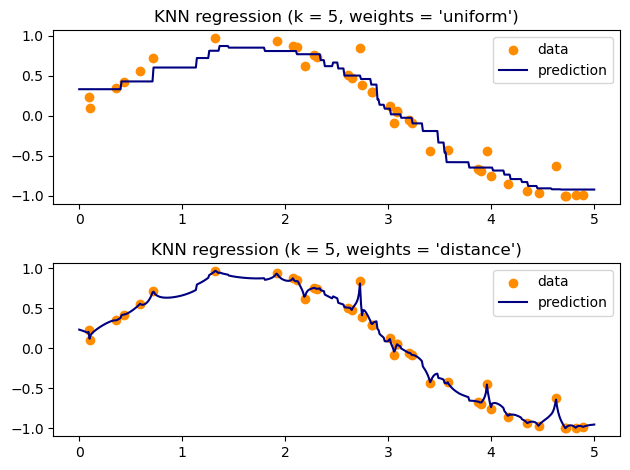

In [10]:
nn = 5

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(nn, weights=weights)
    y_ = knn.fit(X, y).predict(T)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, color='darkorange', label='data')
    plt.plot(T, y_, color='navy', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNN regression (k = %i, weights = '%s')" \
              % (nn, weights))
plt.tight_layout()
plt.show()

### [Example: upper/lower half face matching](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_multioutput_face_completion.html)
- Goal: predict lower half of each face image, given the upper half.
- 1st column = true faces
- 2nd-5th columns = attempted completions using *extra trees*, *KNN*, *linear regression*, *ridge regression*.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces as Fetch
from sklearn.utils.validation import check_random_state as Check

from sklearn.ensemble import ExtraTreesRegressor as ETR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import RidgeCV

In [12]:
# dataset
data, targets = Fetch(return_X_y=True)
train = data[targets < 30]
test  = data[targets >= 30]

In [13]:
# Test on a subset of people
n_faces  = 5
rng      = Check(4)
face_ids = rng.randint(test.shape[0], size=(n_faces, ))
test     = test[face_ids, :]

n_pixels = data.shape[1]
X_train  = train[:, :(n_pixels + 1) // 2] # Upper half of the faces
y_train  = train[:,   n_pixels      // 2:] # Lower half of the faces
X_test   =  test[:, :(n_pixels + 1) // 2]
y_test   =  test[:,   n_pixels      // 2:]

In [14]:
ESTIMATORS = {
    "Extra trees": ETR(n_estimators=10, 
                       max_features=32,
                       random_state=0),
    "K-nn": KNR(),
    "Linear regression": LR(),
    "Ridge": RidgeCV(),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    y_test_predict[name] = estimator.predict(X_test)

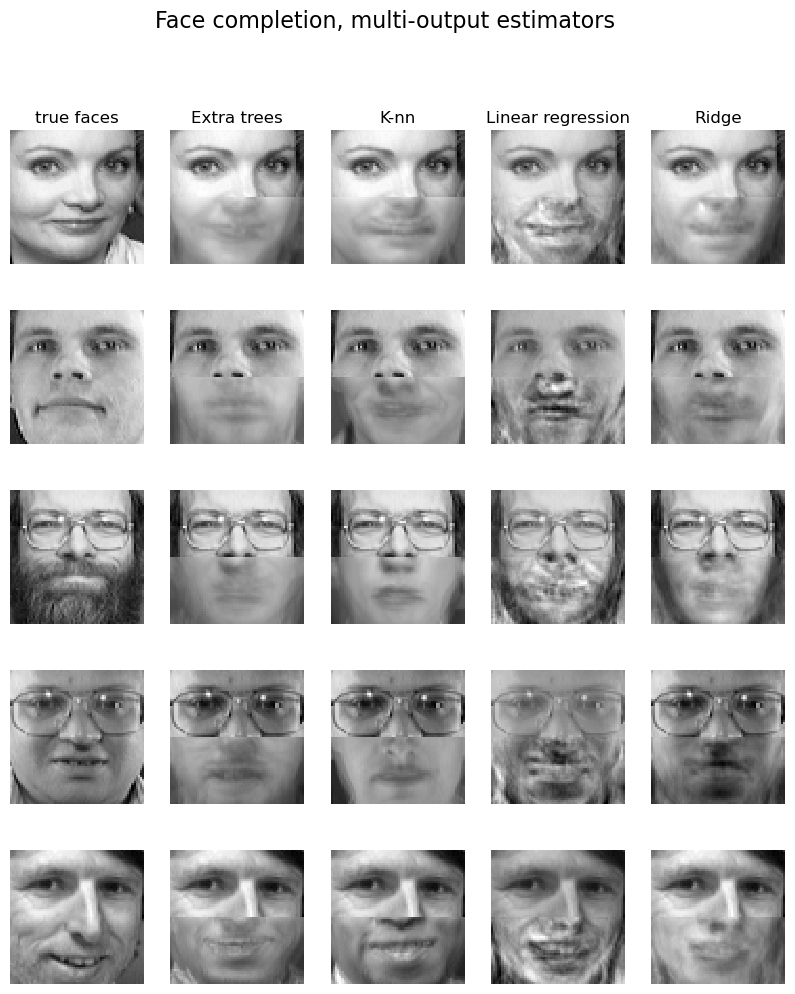

In [15]:
image_shape, n_cols = (64, 64), 1+len(ESTIMATORS)

plt.figure(figsize=(2.0* n_cols, 2.26*n_faces))
plt.suptitle("Face completion, multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i*n_cols+1)
    else:
        sub = plt.subplot(n_faces, n_cols, i*n_cols+1, title="true faces")

    sub.axis("off")
    sub.imshow(true_face.reshape(image_shape),
               cmap=plt.cm.gray,
               interpolation="nearest")

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i*n_cols+2+j)
        else:
            sub = plt.subplot(n_faces, n_cols, i*n_cols+2+j, title=est)

        sub.axis("off")
        sub.imshow(completed_face.reshape(image_shape),
                   cmap=plt.cm.gray,
                   interpolation="nearest")
plt.show()

### Algorithm Comparison
- **Brute Force** (`algorithm=brute`): computational complexity scales with $N$ samples in $D$ dimensions as $O[D N^2]$. Quickly becomes unfeasible for anything beyond small datasets.
- **Automatic** (`algorithm='auto`): selects `brute force` if:
    - input data = sparse
    - `metric = 'precomputed'`
    - D>15
    - k>=N/2
    - `effective_metric` isn't in the `VALID_METRICS` list 

- **[KD Tree](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_multioutput_face_completion.html)** ("K dimensional tree") ('algorithm=kdtree'): 
    - An example of reducing distance calculations by **encoding aggregate distances**. (If A is distant from B, and B is close to C, then A & C are assumed to be distant from each other.) 
    - Computational complexity scales as $O[D N \log(N)]$.
    - **Binary tree structure** - recursively divides a parameter space into nested orthotropic regions. Very fast construction.
    - Once built, NN calculation for a single point is $O[\log(N)]$.
    - Very fast for $D$<20 datasets, but bogs down for high-D datasets.

- **[Ball Tree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)** (`algorithm=ball_tree`):
    - Better than KD Tree in high-D problems.
    - Partitions data into **nesting hyperspheres** (not Cartesian).
    - Slower construction, but efficient NN calculations
    - Nodes are defined by centroid $C$ and radius $r$.
    - Number of candidate points for a NN search uses a triangle inequality relation for reduction: $|x+y| \leq |x| + |y|$.

### [Nearest Centroid](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html#sklearn.neighbors.NearestCentroid) Classifier
- Represents each class with the *centroid of its members*.
- No parameters to tune, so it can be a decent baseline classifier.
- Suffers on non-convex classes, data with signficantly different variances. (equal variance in all dimensions is assumed).
- LDA & QDA do not make this assumption.

In [16]:
from sklearn.neighbors import NearestCentroid
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])

clf = NearestCentroid(); clf.fit(X, y); print(clf.predict([[-0.8, -1]]))

[1]


- [Nearest Centroid](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html#sklearn.neighbors.NearestCentroid) can use `shrink_threshold` parameter to divide the value of each feature by its within-class variance, then reduce it by `shrink_threshold`. 
- This is useful for overly noisy datasets.

### [Example: nearest centroid classification - shrink threshold analysis](https://scikit-learn.org/stable/auto_examples/neighbors/plot_nearest_centroid.html)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.neighbors import NearestCentroid as NC

In [18]:
nn,h = 15, 0.02

iris = datasets.load_iris()
X,y = iris.data[:, :2], iris.target

shrinkage:	 None 0.8133333333333334
shrinkage:	 0.2 0.82


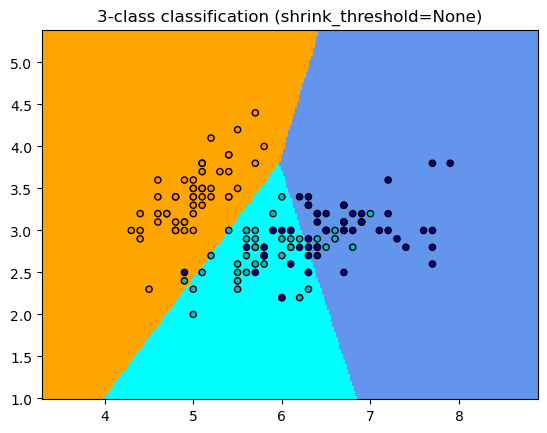

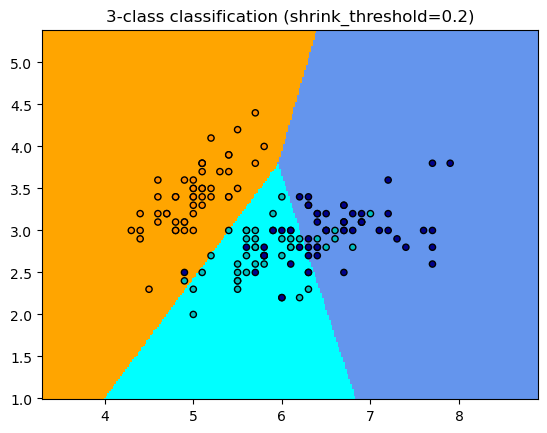

In [19]:
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for shrinkage in [None, .2]:
    clf = NC(shrink_threshold=shrinkage)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    
    print("shrinkage:\t",shrinkage, np.mean(y == y_pred))

    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading="auto")
    plt.scatter(X[:, 0], 
                X[:, 1], 
                c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.title("3-class classification (shrink_threshold=%r)"
              % shrinkage)
    plt.axis('tight')
plt.show()

### [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsTransformer.html#sklearn.neighbors.KNeighborsTransformer) and [Radius-based NN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsTransformer.html#sklearn.neighbors.RadiusNeighborsTransformer) Transformers

- Many Scikit-Learn methods rely on NNs. Most can compute NNs on their own **and** use precomputed sparse graphs from [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html#sklearn.neighbors.kneighbors_graph) and [there](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.radius_neighbors_graph.html#sklearn.neighbors.radius_neighbors_graph).
- Example: **SpectralClustering** can use a sparse binary adjacency graph  via `mode="connectivity"`.
- Example: **DBSCAN** can use a sparse distance graph via `mode="distance"`.
- Use NN transformers in a pipeline to include these functions.

In [20]:
from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsTransformer as KNT
from sklearn.pipeline import make_pipeline

estimator = make_pipeline(
    KNT(n_neighbors=5, 
        mode='distance'),
    Isomap(neighbors_algorithm='precomputed'),
    #memory='/path/to/cache'
)

### Why use a precomputed graph?
- They can be reused while varying the parameters.
- They can provide fine-tuned control, for example parallel processing via `n_jobs` (not available on all estimators).
- They can be specialized for custom jobs (approximate NNs, special data types, ...)
- When the #neighbors is specified, the definition is ambiguous - it can, or may not, include each training point as its own neighbor.
- **KNeighborsTransformer** includes each training point as its own neighbor by default. One extra neighbor will be computed by using `mode="distance"`, for compatibility with other estimators. The safe choice is to always include one extra neighbor.

### [Example: Approximate NNs pipelined to TSNE](https://scikit-learn.org/stable/auto_examples/neighbors/approximate_nearest_neighbors.html#sphx-glr-auto-examples-neighbors-approximate-nearest-neighbors-py)
- **TODO: SOLVE library install problem**
- How to chain K neighbors Transformer and TSNE

### [Neighborhood Components Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NeighborhoodComponentsAnalysis.html#sklearn.neighbors.NeighborhoodComponentsAnalysis)
- A distance learning algorithm. The goal is to improve NN classification accuracy vs using standard Euclidean distance.
- It maximizes a stochastic variant of the Leave-One-Out (LOO) KNN scoring on a training set.
- It can also learn a low-D linear projection for visualization & fast classification.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
from matplotlib import cm
from scipy.special import logsumexp

- create 9 samples from 3 classes. focus on point #3. link thickness between #3 and any other point is proportional to distance.

In [28]:
X, y = make_classification(n_samples=9, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=3, n_clusters_per_class=1,
                           class_sep=1.0, random_state=0)

In [29]:
def link_thickness_i(X, i):
    diff_embedded = X[i] - X
    dist_embedded = np.einsum('ij,ij->i', diff_embedded,
                              diff_embedded)
    dist_embedded[i] = np.inf

    # compute exponentiated distances (use the log-sum-exp trick to
    # avoid numerical instabilities...
    exp_dist_embedded = np.exp(-dist_embedded -
                               logsumexp(-dist_embedded))
    return exp_dist_embedded


def relate_point(X, i, ax):
    pt_i = X[i]
    for j, pt_j in enumerate(X):
        thickness = link_thickness_i(X, i)*3
        if i != j:
            line = ([pt_i[0], pt_j[0]], [pt_i[1], pt_j[1]])
            ax.plot(*line, c=cm.Set1(y[j]),
                    linewidth=5*thickness[j])

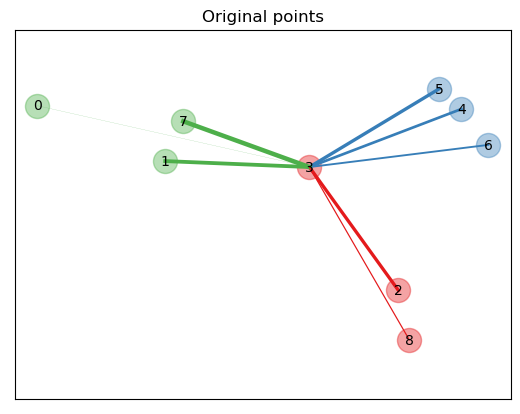

In [27]:
plt.figure(1)
ax = plt.gca()
for i in range(X.shape[0]):
    ax.text(   X[i, 0], X[i, 1], str(i), va='center', ha='center')
    ax.scatter(X[i, 0], X[i, 1], s=300, c=cm.Set1(y[[i]]), alpha=0.4)

ax.set_title("Original points")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.axis('equal')  # so that boundaries are displayed correctly as circles
i = 3
relate_point(X, i, ax)
plt.show()

### [Example: Using NCA to learn an embedding](https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_illustration.html#learning-an-embedding)
- Use NCA to learn an embedding & plot post-transformation points.
- Use embedding to find the NNs.

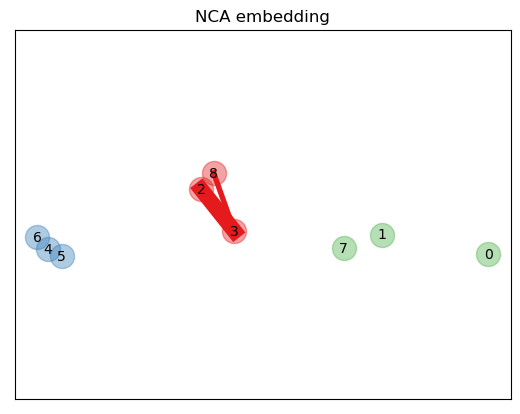

In [30]:
nca = NCA(max_iter=30, random_state=0)
nca = nca.fit(X, y)

plt.figure(2)
ax2 = plt.gca()
X_embedded = nca.transform(X)
relate_point(X_embedded, i, ax2)

for i in range(len(X)):
    ax2.text(X_embedded[i, 0], X_embedded[i, 1], str(i),
             va='center', ha='center')
    ax2.scatter(X_embedded[i, 0], X_embedded[i, 1], s=300, c=cm.Set1(y[[i]]),
                alpha=0.4)

ax2.set_title("NCA embedding")
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.axis('equal')
plt.show()

### [NCA Classification](https://scikit-learn.org/stable/modules/neighbors.html#id4)
- Handles **multiclass problems** without model size blowup, and does not require additional parameters for tuning.
- Does not make any assumptions about underlying distributions.
- Combine an NCA instance that learns a transformation with KN Classifier to do the classification in the projected space.

In [31]:
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.7, random_state=42)

nca      = NeighborhoodComponentsAnalysis(random_state=42)
knn      = KNeighborsClassifier(n_neighbors=3)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])

nca_pipe.fit(X_train, y_train)
print("score:\t",nca_pipe.score(X_test, y_test))

score:	 0.9619047619047619


### [Example: NN classification with/without NCA](https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_classification.html)
- Plot decision boundries from a NN classifier, using Euclidean distance metric
- Compare before/after applying NCA
- The latter looks for a linear transformation that maximizes the stochastic NN classification accuracy.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import (KNeighborsClassifier as KNC,
                               NeighborhoodComponentsAnalysis as NCA)
from sklearn.pipeline import Pipeline

In [33]:
n_neighbors = 1

dataset = datasets.load_iris()
X, y = dataset.data, dataset.target
X = X[:, [0, 2]]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, test_size=0.7, random_state=42)

h          = .01  # step size in the mesh
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
names      = ['KNN', 'NCA, KNN']

classifiers = [Pipeline([('scaler', StandardScaler()),
                         ('knn', KNC(n_neighbors=n_neighbors))
                         ]),
               Pipeline([('scaler', StandardScaler()),
                         ('nca', NCA()),
                         ('knn', KNC(n_neighbors=n_neighbors))
                         ])]

In [34]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

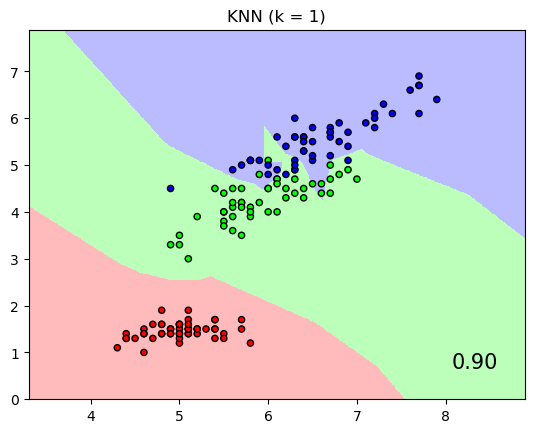

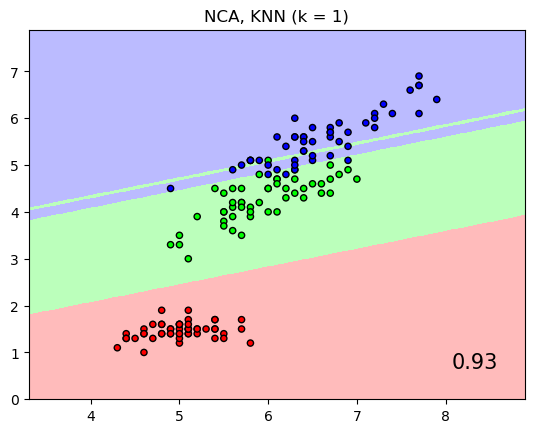

In [35]:
for name, clf in zip(names, classifiers):

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=.8, shading='auto')

    # Plot also the training and testing points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("{} (k = {})".format(name, n_neighbors))
    plt.text(0.9, 0.1, '{:.2f}'.format(score), size=15,
             ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

### NCA and Dimensionality Reduction
- Inputs are projected to a linear subspace built from directions that minimize NCA's objective.
- Dimensionality can be set using `n_components`.

### [Example: Dimensionality Reduction - NCA vs LDA vs PCA](https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html)
- LDA: Linear Discriminant Analysis: identifies attributes that cause the most **between-class** variance.
- PCA: Principal Component Analysis: identifies attributes that cause the most **between-samples** variance.
- NCA: finds a feature space so that a stochastic NN algorithm provides best accuracy.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import (KNeighborsClassifier as KNC,
                               NeighborhoodComponentsAnalysis as NCA)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [37]:
n_neighbors = 3
random_state = 0

# Load Digits dataset
X, y = datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, stratify=y, random_state=random_state)

dim = len(X[0])
nn  = len(np.unique(y))

In [38]:
# Reduce dimension to 2 with PCA, LDA, NCA

pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))
lda = make_pipeline(StandardScaler(), LDA(n_components=2))
nca = make_pipeline(StandardScaler(), NCA(n_components=2, random_state=random_state))

In [39]:
# Use a nearest neighbor classifier to evaluate the methods
knn = KNC(n_neighbors=n_neighbors)
methods = [('PCA', pca), ('LDA', lda), ('NCA', nca)]


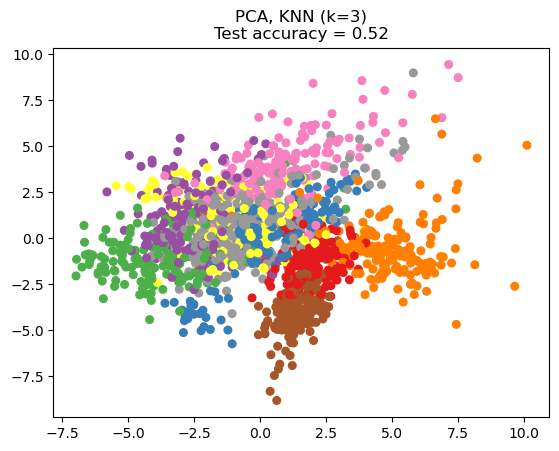

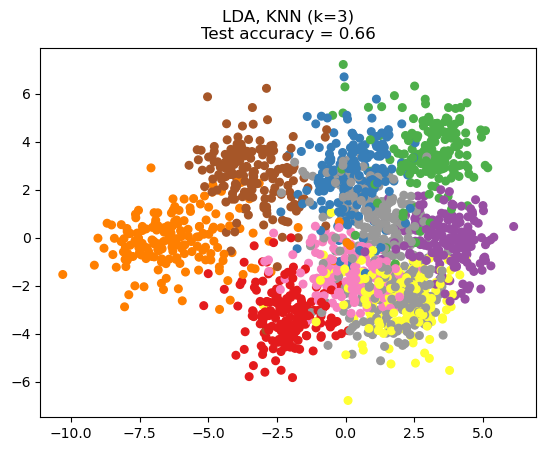

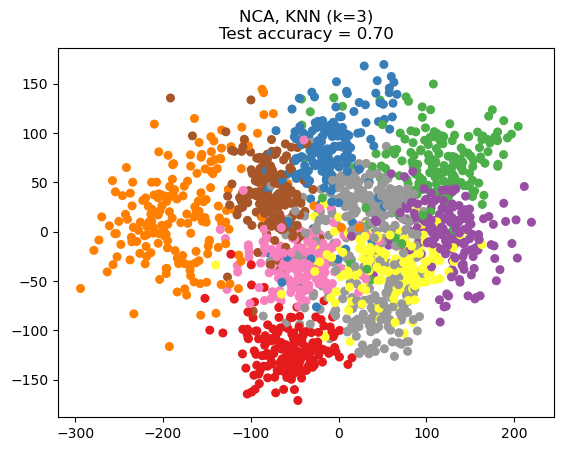

In [40]:
for i, (name, model) in enumerate(methods):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    model.fit(X_train, y_train)
    knn.fit(model.transform(X_train), y_train)
    acc_knn = knn.score(model.transform(X_test), y_test)
    X_embedded = model.transform(X)

    plt.scatter(X_embedded[:, 0], 
                X_embedded[:, 1], 
                c=y, s=30, cmap='Set1')

    plt.title("{}, KNN (k={})\nTest accuracy = {:.2f}".format(name,
                                                              n_neighbors,
                                                              acc_knn))
plt.show()